# AD11 - Leitura paralela de dados

O objetivo é demonstrar a aceleração quando se lê os dados em paralelo (uma thread de leitura por disco). Para tal, usaremos o PCAD e discos locais aos nós computacionais. Para realizar este experimento, o professor lançará este notebook na máquina `cei1` (143.54.48.109) com o comando:

```{bash}
jupyter notebook --port=8787 --ip=143.54.48.109
```

Empregaremos a porta `8787` por ela já estar liberada no firewall da gppd-hpc.inf.ufrgs.br e adequadamente redirecionada para a máquina `cei`.

## Geração de dados aleatórios

### Gerar uma tabela com 6.8 GBytes

Vamos gerar uma tabela com duas colunas e 800 milhões de valores aleatórios distribuídos de maneira uniforme entre 0 e 1. Empregamos `np.random.random` para em seguidar fazer o `reshape` antes de importar para `dask.dataframe` com o método `from_array`. Em seguida, alteramos o particionamento para 2 e salvamos o arquivo no formato `parquet`.

In [ ]:
import numpy as np
import dask
import dask.dataframe as dd

dd.from_array(np.random.random(800000000).reshape((-1,2)),
              columns=["x", "by"]) \
    .repartition(2) \
    .to_parquet("save.parquet")

Teremos então um diretório com dois arquivos, cada um com aproximadamente 3.4GBytes.

In [ ]:
!ls -lh save.parquet

Para fins de ilustração, o diretório `save.parquet` é copiado manualmente com `rsync` para discos locais em dois nós computacionais do PCAD (cei1, cei2), de maneira que a leitura desses arquivos possa ser efetivamente realizada em paralelo.

Em seguida, ainda manualmente, é criado um diretório `save2.parquet` no local deste notebook. O diretório contém dois links simbólicos que apontam para os arquivos nos discos locais. Isso é feito nas duas máquinas.

# Instanciando o cluster

Vamos agora instanciar o `dask-scheduler` na máquina `cei1`:

```{bash}
dask-scheduler --no-jupyter --no-dashboard
```

E agora vamos instanciar os dois workers com uma thread cada um.

Cada worker é instanciado em um nó diferente.

```{bash}
dask-worker \
    --memory-limit=96GB \
    --nthreads=1 \
    tcp://143.54.48.109:8786
```

# Leitura dos dados

Para a leitura dos dados, vamos nos conectar no cluster.

In [ ]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client("localhost:8786")
client

<Client: 'tcp://143.54.48.109:8786' processes=2 threads=2, memory=178.81 GiB>

Vamos formar uma consulta que envolve todos os dados.

Calcular a média dos valores na coluna `x`.

In [ ]:
resposta = dd.read_parquet("save2.parquet").x.mean()

Vamos observar o grafo de tarefas para ver a oportunidade de paralelismo.

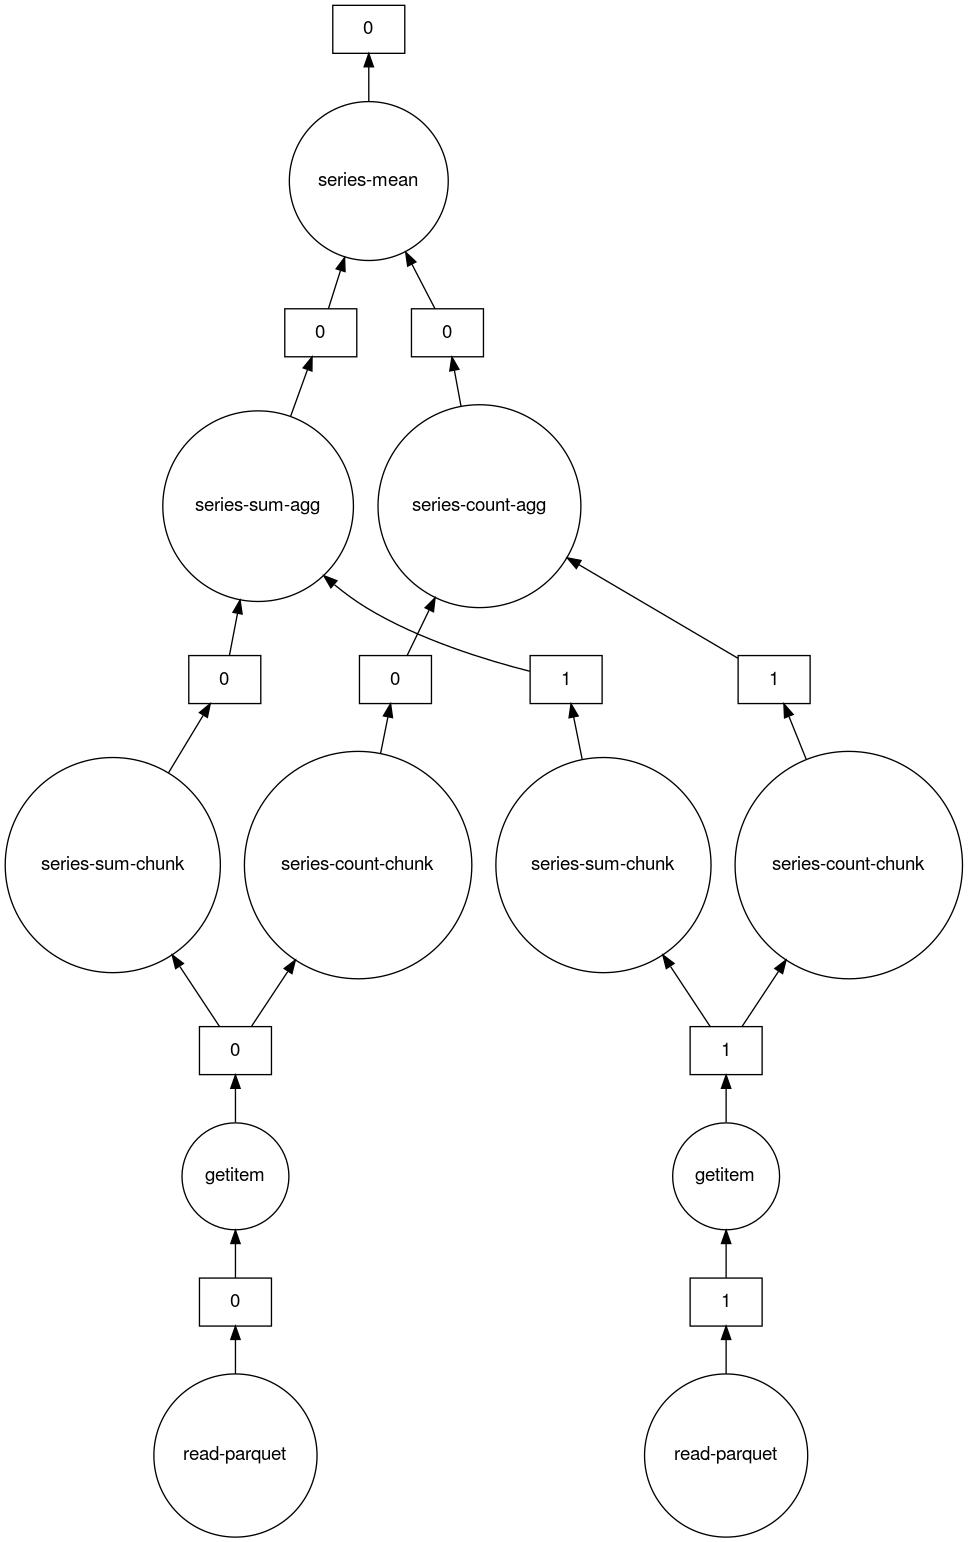

In [ ]:
resposta.visualize()

Antes da execução, vamos lembrar de liberar as caches de disco em memória realizadas:

```{bash}
echo 3 | sudo tee /proc/sys/vm/drop_caches
```

O objetivo aqui é ter uma percepção aproximadamente do tempo de leitura do disco.

In [ ]:
%%time
resposta.compute()

CPU times: user 14.2 ms, sys: 3.74 ms, total: 17.9 ms
Wall time: 12.6 s


0.4999962036560397

Vamos desconectar o cliente solicitando o encerramento do cluster.

In [ ]:
client.shutdown()

Conclusões:
1. Com um worker, ~25s para realizar o procedimento
2. Com dois workers, ~12s para realizar o procedimento